In [4]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [5]:
import sys
sys.path.append("../")

In [6]:
import torch
from torch import nn

from models.embedding import SphericalGraphCNN

/home/sm8383/anaconda3/lib/python3.8/site-packages/PyGSP-0.5.1-py3.8.egg/pygsp/filters/simpletight.py:76: SyntaxWarning: "is" with a literal. Did you mean "=="?
/home/sm8383/anaconda3/lib/python3.8/site-packages/PyGSP-0.5.1-py3.8.egg/pygsp/filters/simpletight.py:79: SyntaxWarning: "is" with a literal. Did you mean "=="?
/home/sm8383/anaconda3/lib/python3.8/site-packages/PyGSP-0.5.1-py3.8.egg/pygsp/filters/simpletight.py:76: SyntaxWarning: "is" with a literal. Did you mean "=="?
/home/sm8383/anaconda3/lib/python3.8/site-packages/PyGSP-0.5.1-py3.8.egg/pygsp/filters/simpletight.py:79: SyntaxWarning: "is" with a literal. Did you mean "=="?


In [7]:
nside_list = [128, 64, 32, 16, 8, 4, 2]

In [8]:
sys.path.append("../../fermi-gce-gp/")
from utils import create_mask as cm

hp_mask_nside1 = cm.make_mask_total(nside=1, band_mask = True, band_mask_range = 0,
                              mask_ring = True, inner = 0, outer = 25)

indexes_list = []
masks_list = []
for nside in nside_list:
    hp_mask = hp.ud_grade(hp_mask_nside1, nside)
    masks_list.append(hp_mask)
    indexes_list.append(np.arange(hp.nside2npix(nside))[~hp_mask])

In [9]:
ps_mask = np.load("../../fermi-gce-gp/data/mask_3fgl_0p8deg.npy")
hp_mask = cm.make_mask_total(nside=128, band_mask = True, band_mask_range = 0,
                              mask_ring = True, inner = 0, outer = 25, custom_mask=ps_mask)
hp_mask

array([ True,  True,  True, ...,  True,  True,  True])

torch.Size([1, 16384, 1])

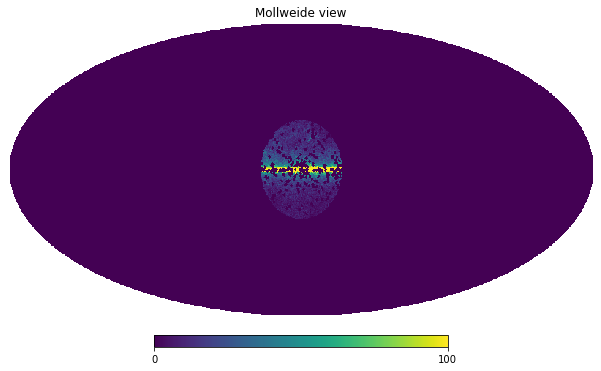

In [10]:
in_map = np.load("../../fermi-gce-gp/data/fermi_data/fermidata_counts.npy")
in_map[hp_mask] = 0

hp.mollview(in_map, max=100)

in_map = torch.Tensor(in_map[~masks_list[0]])
in_map = in_map.reshape((1, -1, 1))
in_map.shape

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


In [12]:
sg = SphericalGraphCNN(nside_list, indexes_list).to(device)

In [13]:
in_map.shape

torch.Size([1, 16384, 1])

In [14]:
in_map = in_map.to(device)

In [15]:
sg(in_map).shape

torch.Size([1, 64])

In [16]:
temp_gce = np.load("../data/fermi_data/template_gce.npy")

In [17]:
from models.scd import dnds
from utils.psf_correction import PSFCorrection
from utils.utils import make_dirs
from models.psf import KingPSF

In [18]:
kp = KingPSF()

pc_inst = PSFCorrection(delay_compute=True)
pc_inst.psf_r_func = lambda r: kp.psf_fermi_r(r)

In [19]:
from simulations.simulate_ps import SimulateMap

In [20]:
from sbi import utils
from sbi import inference
from sbi.inference.base import infer

In [21]:
in_map.shape

torch.Size([1, 16384, 1])

In [22]:
# def simulator_model(parameter):
#     s_ary = torch.logspace(-1, 2, 100)
#     dnds_ary = dnds(s_ary, torch.tensor(parameter)).numpy()
#     sm = SimulateMap([],[],[s_ary],[dnds_ary], [temp_gce], pc_inst.psf_r_func, n_exp=[parameter[0]])
#     the_map = np.array(sm.create_map()).astype(np.float32)
#     the_map = the_map.reshape((1, -1))[:, ~masks_list[0]]
#     the_map /= np.mean(the_map)
#     return the_map

def simulator_model(parameter):
    s_ary = torch.logspace(-1, 2, 100)
    dnds_ary = dnds(s_ary, torch.tensor([5., 15., parameter[1], -10., 20, 1.])).numpy()
    sm = SimulateMap([],[],[s_ary],[dnds_ary], [temp_gce], pc_inst.psf_r_func, n_exp=[10 ** parameter[0]])
    the_map = np.array(sm.create_map()).astype(np.float32)
    the_map = the_map.reshape((1, -1))[:, ~masks_list[0]]
    the_map /= np.mean(the_map)
    return the_map

In [24]:
parameter = [3, 10., 1.9, -10., 20., 0.1]
simulator_model(parameter)

array([[0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [25]:
from tqdm import *

In [26]:
number_presimulated = 1000

# prior = utils.BoxUniform(low=torch.tensor([0., 10., 1.1, -10., 5., 0.1]), 
#                          high=torch.tensor([1000., 20., 1.9, 1.9, 50., 4.99]))

prior = utils.BoxUniform(low=torch.tensor([-1., 1.1]), 
                         high=torch.tensor([3., 1.9]))

theta_presimulated = prior.sample((number_presimulated,))

x_presimulated = [simulator_model(theta) for theta in tqdm(theta_presimulated)]

  0%|          | 0/1000 [00:00<?, ?it/s]<ipython-input-22-1783c9959e50>:16: RuntimeWarning: invalid value encountered in true_divide
  the_map /= np.mean(the_map)
100%|██████████| 1000/1000 [04:05<00:00,  4.07it/s]


In [27]:
theta_presimulated = torch.Tensor(theta_presimulated)
x_presimulated = torch.Tensor(x_presimulated)

In [28]:
x_presimulated[x_presimulated != x_presimulated] = 0.

In [29]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter()

In [30]:
sg_embed = SphericalGraphCNN(nside_list, indexes_list)

In [31]:
# set prior distribution for the parameters 
# prior = utils.BoxUniform(low=torch.tensor([0., 10., 1.1, -10., 5., 0.1]), 
#                          high=torch.tensor([1000., 20., 1.9, 1.9, 50., 4.99]))

prior = utils.BoxUniform(low=torch.tensor([-1., 1.1]), 
                         high=torch.tensor([3., 1.9]))

# make a SBI-wrapper on the simulator object for compatibility
simulator_wrapper, prior = inference.prepare_for_sbi(simulator_model, prior)

# # instantiate the neural density estimator
# neural_classifier = utils.classifier_nn(model='linear',
#                                       embedding_net_x=sg)

# # setup the inference procedure with the SNPE-C procedure
# inference_inst = inference.SNRE_A(simulator_wrapper, prior,
#                            classifier=neural_classifier, 
#                            show_progress_bars=True, show_round_summary=True, 
#                            logging_level='INFO',
#                            summary_writer=writer,
#                            mcmc_method='hmc')

# instantiate the neural density estimator
neural_classifier = utils.posterior_nn(model='maf',
                                      embedding_net=sg_embed,
                                      hidden_features=50,
                                      num_transforms=4,
)

# setup the inference procedure with the SNPE-C procedure
inference_inst = inference.SNPE(simulator_wrapper, prior,
                           density_estimator=neural_classifier, 
                           show_progress_bars=True, show_round_summary=True, 
                           logging_level='INFO',
#                            summary_writer=writer,
                                 sample_with_mcmc=True,
                                 mcmc_method="slice_np",
                                 device=device)

<ipython-input-22-1783c9959e50>:16: RuntimeWarning: invalid value encountered in true_divide
  the_map /= np.mean(the_map)
/home/sm8383/anaconda3/lib/python3.8/site-packages/sbi-0.13.2-py3.8.egg/sbi/utils/torchutils.py:26: UserWarning: GPU was selected as a device for training the neural network. Note
                   that we expect **no** significant speed ups in training for the
                   default architectures we provide. Using the GPU will be effective
                   only for large neural networks with operations that are fast on the
                   GPU, e.g., for a CNN or RNN `embedding_net`.
  warnings.warn(


In [32]:
inference_inst.provide_presimulated(theta_presimulated, x_presimulated[:, 0, :])

In [33]:
# run the inference procedure on one round and 10000 simulated data points
posterior = inference_inst(num_simulations=0, training_batch_size=64, max_num_epochs=200)

Neural network successfully converged after 32 epochs.

        -------------------------
        ||||| ROUND 1 STATS |||||:
        -------------------------
        Epochs trained: 32
        Best validation performance: -0.0074
        Acceptance rate: nan
        -------------------------
        


In [40]:
# generate posterior samples
true_parameter = torch.tensor([2.5, 1.9])
# true_parameter = torch.tensor([300, 10., 1.9, -10., 20., 0.1])
x_observed = simulator_model(true_parameter)
samples = posterior.set_default_x(x_observed).sample((100,))

Generating samples: 100%|██████████| 100/100 [02:40<00:00,  1.60s/it]


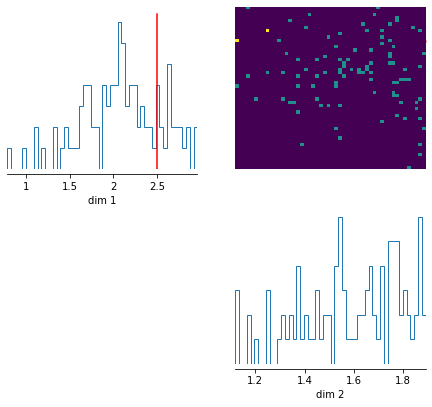

In [42]:
# create the figure
fig, ax = utils.pairplot(samples, 
                             points=true_parameter,
#                              labels=['r', r'$\theta$'], 
#                              limits=[[0, 600], [-2, 0]],
                             points_colors='r',
                             points_offdiag={'markersize': 6},
                             fig_size=[7.5, 6.4])
